In [ ]:
# --- Mount Drive (if in Colab) ---
from google.colab import drive
drive.mount('/content/drive')

# --- Install dependencies (only needed once) ---
# !pip install pandas openpyxl tqdm scikit-learn matplotlib

# --- 1. Load Libraries ---
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# --- 2. Load Your Files ---
healthy_data_path = '/content/drive/MyDrive/ahmad dataset4.5.25/turbine_T01_data.csv'
real_fault_data_path = '/content/drive/MyDrive/ahmad dataset4.5.25/failure_only_sensor_data_with_failure_info (1).csv'

healthy_data = pd.read_csv(healthy_data_path)
real_fault_data = pd.read_csv(real_fault_data_path)

# --- PATCH: Force healthy data to float64 ---
healthy_data = healthy_data.apply(lambda col: col.astype(float) if np.issubdtype(col.dtype, np.number) else col)

# --- 3. Prepare the Real Fault Behavior by Remarks ---
cols_to_ignore = ['Component'] if 'Component' in real_fault_data.columns else []
real_fault_data = real_fault_data.drop(columns=[col for col in cols_to_ignore if col in real_fault_data.columns], errors='ignore')

common_columns = list(set(healthy_data.columns).intersection(set(real_fault_data.columns)))
healthy_data = healthy_data[common_columns]
real_fault_data = real_fault_data[common_columns + ['Remarks']]

remark_patterns = {}
remarks_list = real_fault_data['Remarks'].unique().tolist()

for remark in remarks_list:
    subset = real_fault_data[real_fault_data['Remarks'] == remark].drop(columns=['Remarks'])
    if not subset.empty:
        subset_numeric = subset.select_dtypes(include=[np.number])
        mean_faulty = subset_numeric.mean()
        mean_normal = healthy_data.select_dtypes(include=[np.number]).mean()
        diff_percent = 100 * (mean_faulty - mean_normal) / mean_normal
        significant_sensors = diff_percent[abs(diff_percent) >= 10].index.tolist()
        pattern = {sensor: diff_percent[sensor] for sensor in significant_sensors}
        remark_patterns[remark] = pattern

# --- 4. Define Fault Injection Function ---
def inject_faults(healthy_df, remarks_list, remark_patterns, noise_std_dev=0.3):
    synthetic_df = healthy_df.copy()
    n_total = len(synthetic_df)
    n_faults = random.randint(int(0.20 * n_total), int(0.25 * n_total))

    fault_rows = random.sample(range(n_total), n_faults)
    fault_remarks_per_row = random.choices(remarks_list, k=n_faults)

    synthetic_df['Fault_Flag'] = 0
    synthetic_df['Remarks'] = None

    for idx, remark in zip(fault_rows, fault_remarks_per_row):
        fault_pattern = remark_patterns.get(remark, {})
        for sensor, shift_percent in fault_pattern.items():
            if sensor in synthetic_df.columns:
                # Apply fault shift
                synthetic_df.at[idx, sensor] *= (1 + shift_percent / 100.0)
                # Add small Gaussian noise
                noise = np.random.normal(loc=0.0, scale=noise_std_dev)
                synthetic_df.at[idx, sensor] *= (1 + noise)

        synthetic_df.at[idx, 'Fault_Flag'] = 1
        synthetic_df.at[idx, 'Remarks'] = remark

    return synthetic_df

# --- 5. Split Healthy Data BEFORE Injection (Important!) ---
healthy_train, healthy_test = train_test_split(healthy_data, test_size=0.2, random_state=42)

# PATCH: Reset index after splitting
healthy_train = healthy_train.reset_index(drop=True)
healthy_test = healthy_test.reset_index(drop=True)

# --- 6. Inject Faults into Train and Test Separately ---
print("Injecting faults into TRAIN set...")
synthetic_train = inject_faults(healthy_train, remarks_list, remark_patterns, noise_std_dev=0.3)

print("Injecting faults into TEST set...")
synthetic_test = inject_faults(healthy_test, remarks_list, remark_patterns, noise_std_dev=0.3)

# --- PATCH: Fill missing Remarks with 'Normal' ---
synthetic_train['Remarks'] = synthetic_train['Remarks'].fillna('Normal')
synthetic_test['Remarks'] = synthetic_test['Remarks'].fillna('Normal')

# --- 7. Prepare Features and Labels ---
def prepare_data(df):
    X = df.drop(columns=['Fault_Flag', 'Remarks'])
    X = X.select_dtypes(include=[np.number])
    y = df['Remarks']
    return X, y

X_train, y_train = prepare_data(synthetic_train)
X_test, y_test = prepare_data(synthetic_test)

# --- 8. Label Encoding and Scaling ---
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



Mounted at /content/drive
Injecting faults into TRAIN set...
Injecting faults into TEST set...


In [ ]:
alpha  = 0.6    # controls (1 - Fault-Only Accuracy)
epsilon = 0.4   # controls Model Size
gamma = 0     # controls Training Time
delta = 0     # controls Inference Time
beta   = 0      # controls Model Complexity (currently disabled)


In [ ]:
# --- Grid Search for Best Tradeoff Between Size, Speed, and Fault-Only Accuracy ---

import time
import pickle
import sys
from sklearn.metrics import accuracy_score

# Settings to try
n_estimators_list = [5, 10, 20, 50, 100, 200]
max_depth_list = [3, 5, 7, 10]

max_possible_complexity = max(n_estimators_list) * max(max_depth_list)

results = []

for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        print(f"\nTraining RandomForest with n_estimators={n_estimators}, max_depth={max_depth}...")

        rf_model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            random_state=42
        )

        # Measure training time
        start_train = time.time()
        rf_model.fit(X_train_scaled, y_train_encoded)
        train_time = time.time() - start_train

        # Measure inference time
        start_infer = time.time()
        y_pred = rf_model.predict(X_test_scaled)
        inference_time = time.time() - start_infer

        # Fault-Only Accuracy
        normal_label_index = np.where(le.classes_ == 'Normal')[0][0]
        fault_mask = (y_test_encoded != normal_label_index)
        y_test_faults = y_test_encoded[fault_mask]
        y_pred_faults = y_pred[fault_mask]
        fault_accuracy = accuracy_score(y_test_faults, y_pred_faults)

        # Model Complexity (normalized)
        model_complexity = (n_estimators * max_depth) / max_possible_complexity

        # Model Size
        model_size_bytes = sys.getsizeof(pickle.dumps(rf_model))
        model_size_MB = model_size_bytes / (1024 * 1024)  # MB

        results.append({
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'fault_accuracy': fault_accuracy,
            'model_complexity': model_complexity,
            'train_time_sec': train_time,
            'inference_time_sec': inference_time,
            'model_size_MB': model_size_MB
        })




Training RandomForest with n_estimators=5, max_depth=3...

Training RandomForest with n_estimators=5, max_depth=5...

Training RandomForest with n_estimators=5, max_depth=7...

Training RandomForest with n_estimators=5, max_depth=10...

Training RandomForest with n_estimators=10, max_depth=3...

Training RandomForest with n_estimators=10, max_depth=5...

Training RandomForest with n_estimators=10, max_depth=7...

Training RandomForest with n_estimators=10, max_depth=10...

Training RandomForest with n_estimators=20, max_depth=3...

Training RandomForest with n_estimators=20, max_depth=5...

Training RandomForest with n_estimators=20, max_depth=7...

Training RandomForest with n_estimators=20, max_depth=10...

Training RandomForest with n_estimators=50, max_depth=3...

Training RandomForest with n_estimators=50, max_depth=5...

Training RandomForest with n_estimators=50, max_depth=7...

Training RandomForest with n_estimators=50, max_depth=10...

Training RandomForest with n_estimators

In [ ]:
# --- After Grid Search: Normalize and Calculate Cost ---

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Normalize fields
results_df['normalized_train_time'] = results_df['train_time_sec'] / results_df['train_time_sec'].max()
results_df['normalized_inference_time'] = results_df['inference_time_sec'] / results_df['inference_time_sec'].max()
results_df['normalized_model_size'] = results_df['model_size_MB'] / results_df['model_size_MB'].max()

# Define weights (all equal importance)

# Calculate total cost
results_df['cost'] = (
    alpha * (1 - results_df['fault_accuracy']) +
    beta * results_df['model_complexity'] +
    gamma * results_df['normalized_train_time'] +
    delta * results_df['normalized_inference_time'] +
    epsilon * results_df['normalized_model_size']
)

# --- Find Best Model ---
best_row = results_df.loc[results_df['cost'].idxmin()]

print("\n🎯 Full Grid Search Results (sorted by COST):")
print(results_df.sort_values(by='cost'))

print("\n🚀 Best Parameters Found:")
print(f"n_estimators = {int(best_row['n_estimators'])}")
print(f"max_depth = {int(best_row['max_depth'])}")
print(f"Fault-Only Accuracy = {best_row['fault_accuracy']*100:.2f}%")
print(f"Training Time (s) = {best_row['train_time_sec']:.4f}")
print(f"Inference Time (s) = {best_row['inference_time_sec']:.6f}")
print(f"Model Size (MB) = {best_row['model_size_MB']:.4f}")
print(f"Final Cost = {best_row['cost']:.6f}")



🎯 Full Grid Search Results (sorted by COST):
    n_estimators  max_depth  fault_accuracy  model_complexity  train_time_sec  \
3              5         10        0.932006            0.0250        3.031959   
7             10         10        0.953254            0.0500        5.710330   
6             10          7        0.869157            0.0350        3.316408   
2              5          7        0.839186            0.0175        2.162102   
10            20          7        0.895102            0.0700        7.810614   
11            20         10        0.967569            0.1000        9.724270   
9             20          5        0.727354            0.0500        4.864906   
5             10          5        0.683963            0.0250        2.501787   
1              5          5        0.625363            0.0125        1.329017   
13            50          5        0.789085            0.1250       13.572731   
14            50          7        0.923954            0.1750  

In [ ]:
from sklearn.svm import LinearSVC

# --- LinearSVC Grid Search (Full Cost Evaluation) ---

C_list = [0.01, 0.1, 1, 10]  # Regularization strengths

results_svm = []

for C in C_list:
    print(f"\nTraining LinearSVC with C={C}...")

    svm_model = LinearSVC(
        C=C,
        max_iter=5000,
        random_state=42
    )

    # Measure training time
    start_train = time.time()
    svm_model.fit(X_train_scaled, y_train_encoded)
    train_time = time.time() - start_train

    # Measure inference time
    start_infer = time.time()
    y_pred = svm_model.predict(X_test_scaled)
    inference_time = time.time() - start_infer

    # Fault-Only Accuracy
    normal_label_index = np.where(le.classes_ == 'Normal')[0][0]
    fault_mask = (y_test_encoded != normal_label_index)
    y_test_faults = y_test_encoded[fault_mask]
    y_pred_faults = y_pred[fault_mask]
    fault_accuracy = accuracy_score(y_test_faults, y_pred_faults)

    # Model Complexity (here just 1 for SVM baseline)
    model_complexity = 0.1  # Fix very small complexity

    # Model Size
    model_size_bytes = sys.getsizeof(pickle.dumps(svm_model))
    model_size_MB = model_size_bytes / (1024 * 1024)

    results_svm.append({
        'C': C,
        'fault_accuracy': fault_accuracy,
        'model_complexity': model_complexity,
        'train_time_sec': train_time,
        'inference_time_sec': inference_time,
        'model_size_MB': model_size_MB
    })





Training LinearSVC with C=0.01...

Training LinearSVC with C=0.1...

Training LinearSVC with C=1...

Training LinearSVC with C=10...


In [ ]:
# --- After Grid Search: Normalize and Calculate Cost ---

# Convert to DataFrame
results_svm_df = pd.DataFrame(results_svm)

# Normalize fields
results_svm_df['normalized_train_time'] = results_svm_df['train_time_sec'] / results_svm_df['train_time_sec'].max()
results_svm_df['normalized_inference_time'] = results_svm_df['inference_time_sec'] / results_svm_df['inference_time_sec'].max()
results_svm_df['normalized_model_size'] = results_svm_df['model_size_MB'] / results_svm_df['model_size_MB'].max()



# Calculate total cost
results_svm_df['cost'] = (
    alpha * (1 - results_svm_df['fault_accuracy']) +
    beta * results_svm_df['model_complexity'] +
    gamma * results_svm_df['normalized_train_time'] +
    delta * results_svm_df['normalized_inference_time'] +
    epsilon * results_svm_df['normalized_model_size']
)

# --- Find Best LinearSVC Model ---
best_row_svm = results_svm_df.loc[results_svm_df['cost'].idxmin()]

print("\n🎯 Full LinearSVC Grid Search Results (sorted by COST):")
print(results_svm_df.sort_values(by='cost'))

print("\n🚀 Best LinearSVC Parameters Found:")
print(f"C = {best_row_svm['C']}")
print(f"Fault-Only Accuracy = {best_row_svm['fault_accuracy']*100:.2f}%")
print(f"Training Time (s) = {best_row_svm['train_time_sec']:.4f}")
print(f"Inference Time (s) = {best_row_svm['inference_time_sec']:.6f}")
print(f"Model Size (MB) = {best_row_svm['model_size_MB']:.4f}")
print(f"Final Cost = {best_row_svm['cost']:.6f}")


🎯 Full LinearSVC Grid Search Results (sorted by COST):
       C  fault_accuracy  model_complexity  train_time_sec  \
1   0.10        0.759114               0.1       37.531168   
2   1.00        0.786849               0.1       69.468720   
0   0.01        0.716395               0.1       34.800801   
3  10.00        0.800268               0.1      343.510362   

   inference_time_sec  model_size_MB  normalized_train_time  \
1            0.013324       0.011350               0.109258   
2            0.014375       0.011343               0.202232   
0            0.059555       0.011350               0.101309   
3            0.014328       0.011344               1.000000   

   normalized_inference_time  normalized_model_size      cost  
1                   0.223726               1.000000  0.438862  
2                   0.241377               0.999412  0.452491  
0                   1.000000               1.000000  0.605344  
3                   0.240580               0.999496  0.607884

In [ ]:
# --- MLP Grid Search with Full Cost Evaluation ---

from sklearn.neural_network import MLPClassifier

# MLP parameters to try
hidden_layer_sizes_list = [(64,), (64, 32), (128, 64, 32)]
learning_rate_init_list = [0.001, 0.01]

results_mlp = []

max_possible_complexity_mlp = max([np.prod(layers) for layers in hidden_layer_sizes_list])

for hidden_layers in hidden_layer_sizes_list:
    for learning_rate in learning_rate_init_list:
        print(f"\nTraining MLP with hidden_layers={hidden_layers}, learning_rate_init={learning_rate}...")

        mlp_model = MLPClassifier(
            hidden_layer_sizes=hidden_layers,
            activation='relu',  # Fixed activation
            learning_rate_init=learning_rate,
            max_iter=100,
            random_state=42
        )

        # Measure training time
        start_train = time.time()
        mlp_model.fit(X_train_scaled, y_train_encoded)
        train_time = time.time() - start_train

        # Measure inference time
        start_infer = time.time()
        y_pred = mlp_model.predict(X_test_scaled)
        inference_time = time.time() - start_infer

        # Fault-Only Accuracy
        normal_label_index = np.where(le.classes_ == 'Normal')[0][0]
        fault_mask = (y_test_encoded != normal_label_index)
        y_test_faults = y_test_encoded[fault_mask]
        y_pred_faults = y_pred[fault_mask]
        fault_accuracy = accuracy_score(y_test_faults, y_pred_faults)

        # Define Model Complexity for MLP
        model_complexity = np.prod(hidden_layers) / max_possible_complexity_mlp

        # Model Size
        model_size_bytes = sys.getsizeof(pickle.dumps(mlp_model))
        model_size_MB = model_size_bytes / (1024 * 1024)  # MB

        results_mlp.append({
            'hidden_layers': hidden_layers,
            'learning_rate_init': learning_rate,
            'fault_accuracy': fault_accuracy,
            'model_complexity': model_complexity,
            'train_time_sec': train_time,
            'inference_time_sec': inference_time,
            'model_size_MB': model_size_MB
        })





Training MLP with hidden_layers=(64,), learning_rate_init=0.001...


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



Training MLP with hidden_layers=(64,), learning_rate_init=0.01...

Training MLP with hidden_layers=(64, 32), learning_rate_init=0.001...

Training MLP with hidden_layers=(64, 32), learning_rate_init=0.01...

Training MLP with hidden_layers=(128, 64, 32), learning_rate_init=0.001...

Training MLP with hidden_layers=(128, 64, 32), learning_rate_init=0.01...


In [ ]:
# --- After Grid Search: Normalize and Calculate Cost ---

# Convert to DataFrame
results_mlp_df = pd.DataFrame(results_mlp)

# Normalize fields
results_mlp_df['normalized_train_time'] = results_mlp_df['train_time_sec'] / results_mlp_df['train_time_sec'].max()
results_mlp_df['normalized_inference_time'] = results_mlp_df['inference_time_sec'] / results_mlp_df['inference_time_sec'].max()
results_mlp_df['normalized_model_size'] = results_mlp_df['model_size_MB'] / results_mlp_df['model_size_MB'].max()

# Define weights (all equally important)

# Calculate total cost
results_mlp_df['cost'] = (
    alpha * (1 - results_mlp_df['fault_accuracy']) +
    beta * results_mlp_df['model_complexity'] +
    gamma * results_mlp_df['normalized_train_time'] +
    delta * results_mlp_df['normalized_inference_time'] +
    epsilon * results_mlp_df['normalized_model_size']
)

# --- Find Best MLP Model ---
best_row_mlp = results_mlp_df.loc[results_mlp_df['cost'].idxmin()]

print("\n🎯 Full MLP Grid Search Results (sorted by COST):")
print(results_mlp_df.sort_values(by='cost'))

print("\n🚀 Best MLP Parameters Found:")
print(f"Hidden Layers = {best_row_mlp['hidden_layers']}")
print(f"Learning Rate Init = {best_row_mlp['learning_rate_init']}")
print(f"Fault-Only Accuracy = {best_row_mlp['fault_accuracy']*100:.2f}%")
print(f"Training Time (s) = {best_row_mlp['train_time_sec']:.4f}")
print(f"Inference Time (s) = {best_row_mlp['inference_time_sec']:.6f}")
print(f"Model Size (MB) = {best_row_mlp['model_size_MB']:.4f}")
print(f"Final Cost = {best_row_mlp['cost']:.6f}")


🎯 Full MLP Grid Search Results (sorted by COST):
   hidden_layers  learning_rate_init  fault_accuracy  model_complexity  \
1          (64,)               0.010        0.924402          0.000244   
0          (64,)               0.001        0.931559          0.000244   
3       (64, 32)               0.010        0.917468          0.007812   
2       (64, 32)               0.001        0.927980          0.007812   
4  (128, 64, 32)               0.001        0.924849          1.000000   
5  (128, 64, 32)               0.010        0.913890          1.000000   

   train_time_sec  inference_time_sec  model_size_MB  normalized_train_time  \
1       60.043793            0.037145       0.202085               0.432491   
0      102.436470            0.048159       0.202810               0.737842   
3      108.896152            0.060849       0.249593               0.784370   
2      127.299426            0.091290       0.249899               0.916928   
4      135.716402            0.10037

In [ ]:
# --- Merge Random Forest, MLP, and SVM results together ---
results_df['Model_Type'] = 'RandomForest'
results_mlp_df['Model_Type'] = 'MLP'
results_svm_df['Model_Type'] = 'LinearSVM'

# Merge all
all_results_df = pd.concat([results_df, results_mlp_df, results_svm_df], ignore_index=True)

# --- Global normalization across all models ---
all_results_df['normalized_train_time'] = all_results_df['train_time_sec'] / all_results_df['train_time_sec'].max()
all_results_df['normalized_inference_time'] = all_results_df['inference_time_sec'] / all_results_df['inference_time_sec'].max()
all_results_df['normalized_model_size'] = all_results_df['model_size_MB'] / all_results_df['model_size_MB'].max()

# --- Recalculate global cost ---


all_results_df['cost'] = (
    alpha * (1 - all_results_df['fault_accuracy']) +
    beta * all_results_df['model_complexity'] +
    gamma * all_results_df['normalized_train_time'] +
    delta * all_results_df['normalized_inference_time'] +
    epsilon * all_results_df['normalized_model_size']
)
# --- Best Model Inside Each Model Type After Global Normalization ---

print("\n🎯 BEST MODEL PER TYPE (after global normalization):")

for model_type in all_results_df['Model_Type'].unique():
    model_results = all_results_df[all_results_df['Model_Type'] == model_type]
    best_model = model_results.loc[model_results['cost'].idxmin()]

    print(f"\n🏆 Best for {model_type}:")

    if model_type == 'RandomForest':
        print(f" - n_estimators: {int(best_model['n_estimators'])}")
        print(f" - max_depth: {int(best_model['max_depth'])}")
    elif model_type == 'MLP':
        print(f" - hidden_layers: {best_model['hidden_layers']}")
        print(f" - learning_rate_init: {best_model['learning_rate_init']}")
    elif model_type == 'LinearSVM':
        print(f" - C: {best_model['C']}")

    print(f" - Fault-Only Accuracy: {best_model['fault_accuracy']*100:.2f}%")
    print(f" - Training Time (s): {best_model['train_time_sec']:.4f}")
    print(f" - Inference Time (s): {best_model['inference_time_sec']:.6f}")
    print(f" - Model Size (MB): {best_model['model_size_MB']:.4f}")
    print(f" - Final Cost: {best_model['cost']:.6f}")




🎯 BEST MODEL PER TYPE (after global normalization):

🏆 Best for RandomForest:
 - n_estimators: 10
 - max_depth: 10
 - Fault-Only Accuracy: 95.33%
 - Training Time (s): 5.7103
 - Inference Time (s): 0.036412
 - Model Size (MB): 1.7249
 - Final Cost: 0.047145

🏆 Best for MLP:
 - hidden_layers: (64,)
 - learning_rate_init: 0.001
 - Fault-Only Accuracy: 93.16%
 - Training Time (s): 102.4365
 - Inference Time (s): 0.048159
 - Model Size (MB): 0.2028
 - Final Cost: 0.043310

🏆 Best for LinearSVM:
 - C: 10.0
 - Fault-Only Accuracy: 80.03%
 - Training Time (s): 343.5104
 - Inference Time (s): 0.014328
 - Model Size (MB): 0.0113
 - Final Cost: 0.119965


In [ ]:
# --- Find the best model ---
best_model_row = all_results_df.loc[all_results_df['cost'].idxmin()]

# --- Clean final printing ---
print("\n🎯 FINAL BEST MODEL SELECTION:")
print(f"🏆 Best Model Type: {best_model_row['Model_Type']}")

if best_model_row['Model_Type'] == 'RandomForest':
    print(f" - n_estimators: {int(best_model_row['n_estimators'])}")
    print(f" - max_depth: {int(best_model_row['max_depth'])}")
elif best_model_row['Model_Type'] == 'MLP':
    print(f" - hidden_layers: {best_model_row['hidden_layers']}")
    print(f" - learning_rate_init: {best_model_row['learning_rate_init']}")
elif best_model_row['Model_Type'] == 'LightGBM':
    print(f" - n_estimators: {int(best_model_row['n_estimators'])}")
    print(f" - max_depth: {int(best_model_row['max_depth'])}")
    print(f" - learning_rate: {best_model_row['learning_rate']:.4f}")
elif best_model_row['Model_Type'] == 'LinearSVM':
    print(f" - C: {best_model_row['C']}")

# ✅ Common info for all models:
print(f" - Fault-Only Accuracy: {best_model_row['fault_accuracy']*100:.2f}%")
print(f" - Training Time (s): {best_model_row['train_time_sec']:.4f}")
print(f" - Inference Time (s): {best_model_row['inference_time_sec']:.6f}")
print(f" - Model Size (MB): {best_model_row['model_size_MB']:.4f}")
print(f" - Final Cost: {best_model_row['cost']:.6f}")



🎯 FINAL BEST MODEL SELECTION:
🏆 Best Model Type: MLP
 - hidden_layers: (64,)
 - learning_rate_init: 0.001
 - Fault-Only Accuracy: 93.16%
 - Training Time (s): 102.4365
 - Inference Time (s): 0.048159
 - Model Size (MB): 0.2028
 - Final Cost: 0.043310


<ipython-input-17-5171bc321c0f>:48: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


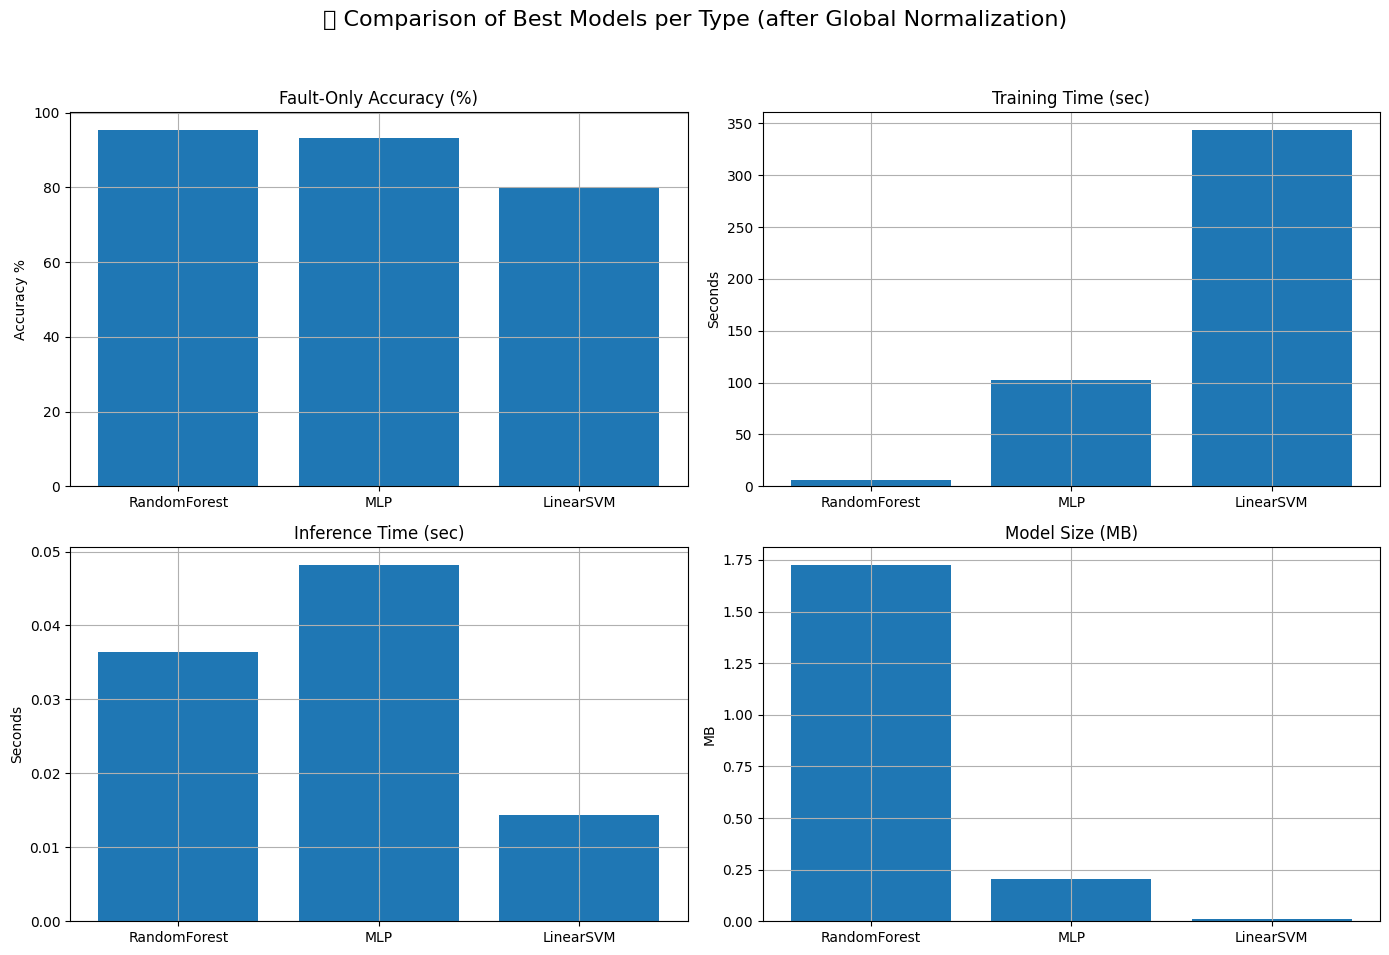

In [ ]:
import matplotlib.pyplot as plt

# --- 1. Find the Best Model per Type ---
best_per_model_type = []

for model_type in all_results_df['Model_Type'].unique():
    model_results = all_results_df[all_results_df['Model_Type'] == model_type]
    best_model = model_results.loc[model_results['cost'].idxmin()]
    best_per_model_type.append({
        'Model_Type': model_type,
        'Fault_Accuracy': best_model['fault_accuracy'],
        'Training_Time': best_model['train_time_sec'],
        'Inference_Time': best_model['inference_time_sec'],
        'Model_Size_MB': best_model['model_size_MB'],
        'Final_Cost': best_model['cost']
    })

best_per_model_df = pd.DataFrame(best_per_model_type)

# --- 2. Plotting ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Fault Accuracy
axes[0, 0].bar(best_per_model_df['Model_Type'], best_per_model_df['Fault_Accuracy'] * 100)
axes[0, 0].set_title('Fault-Only Accuracy (%)')
axes[0, 0].set_ylabel('Accuracy %')
axes[0, 0].grid(True)

# Training Time
axes[0, 1].bar(best_per_model_df['Model_Type'], best_per_model_df['Training_Time'])
axes[0, 1].set_title('Training Time (sec)')
axes[0, 1].set_ylabel('Seconds')
axes[0, 1].grid(True)

# Inference Time
axes[1, 0].bar(best_per_model_df['Model_Type'], best_per_model_df['Inference_Time'])
axes[1, 0].set_title('Inference Time (sec)')
axes[1, 0].set_ylabel('Seconds')
axes[1, 0].grid(True)

# Model Size (MB) instead of Final Cost
axes[1, 1].bar(best_per_model_df['Model_Type'], best_per_model_df['Model_Size_MB'])
axes[1, 1].set_title('Model Size (MB)')
axes[1, 1].set_ylabel('MB')
axes[1, 1].grid(True)

plt.suptitle('📊 Comparison of Best Models per Type (after Global Normalization)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
